In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
using BenchmarkTools;
using CUDA
using Base: @doc
using Revise
using Fmt: @f_str, format # Python-style f-strings
using Random: shuffle, randperm

push!(LOAD_PATH, "../../../src");
using Pose2D
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [3]:
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: ProductDistribution

const diagnormal = broadcasted_normal

mvuniform = ProductDistribution(uniform);
include("../../../src/house_expo_utils.jl");

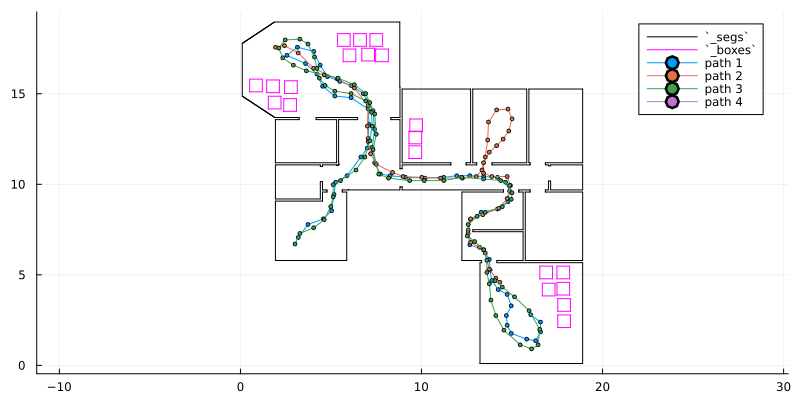

In [4]:

fname = "../data/task_inputs/test_env_2.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=2, c=col[i], label="path $i")
end
mypl

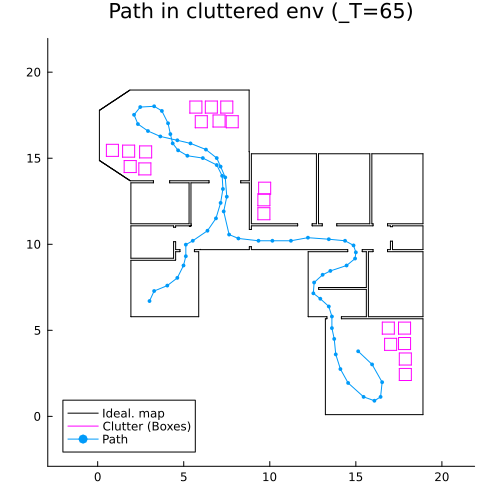

In [5]:
_ps, _us = unpack_path(_paths[3])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [6]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
    _obs_noise = 0.1
    _fov       = 2π
    _num_a     = 361
    _zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 300

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



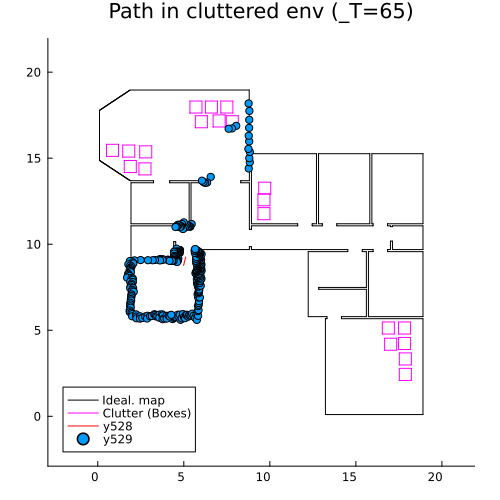

In [7]:
t=5
# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[t], c=:red)
scatter!(polar_inv(_zs[t],_as) .* _ps[t])
mypl

In [8]:
ds = _zs[t] .- [_zs[t][[end]];_zs[t][1:end-1]]
ys = polar_inv(_zs[t],_as)

size(ds), size(ys)

((300,), (300,))

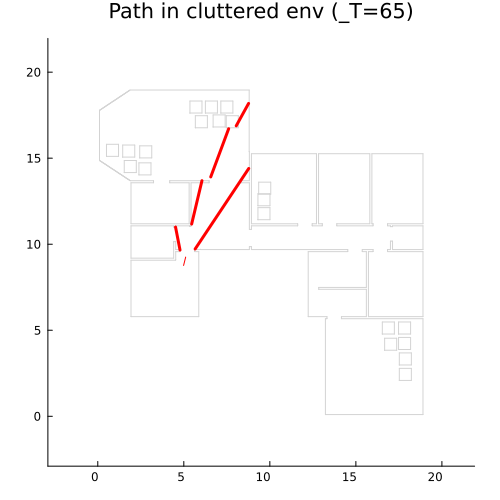

In [10]:
ds = abs.(_zs[t] .- [_zs[t][[end]];_zs[t][1:end-1]])
ys = polar_inv(_zs[t],_as)
thresh = mean(ds) + 2*std(ds)
# -----------------------
# mypl = plot(size=(500,500), aspect_ratio=:equal, grid=true, legend=:bottomleft)
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:lightgray, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:lightgray, label="Clutter (Boxes)")
plot!(_ps[t], c=:red)
for (d,x,y) in zip(ds,ys,[ys[[end]];ys[1:end-1]])
    c = d > thresh ? :red : :blue
    if d > thresh
        plot!([x,y] .* _ps[t], c=c, linewidth=3, legend=nothing)
    end
end
# plot!(segments(polar_inv(_zs[t],_as)), c=:black, marker=:o)
# display(plot(_zs[t], marker=:o))
# display(plot(d, marker=:o))
mypl

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/dev/v3/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/dev/v3/tmp.gif")
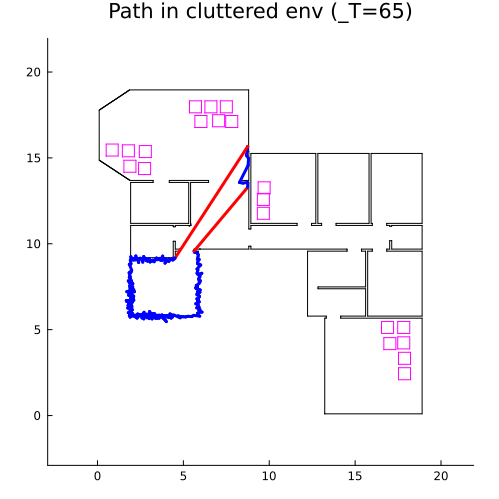

In [77]:
# -----------------------
ani = Animation()
for t=1:1:_T
    ds = abs.(_zs[t] .- [_zs[t][[end]];_zs[t][1:end-1]])
    ys = polar_inv(_zs[t],_as)
    thresh = mean(ds) + 2*std(ds)
    # -----------------------
    # mypl = plot(size=(500,500), aspect_ratio=:equal, grid=true, legend=:bottomleft)
    mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
    plot!(_boxes, c=:black, label="Clutter (Boxes)")
    for (d,x,y) in zip(ds,ys,[ys[[end]];ys[1:end-1]])
        c = d > thresh ? :red : :blue
        plot!([x,y] .* _ps[t], c=c, linewidth=3, legend=nothing)
    end

    frame(ani, mypl)
end
gif(ani, fps=4)

(300, 9)
(300, 1)


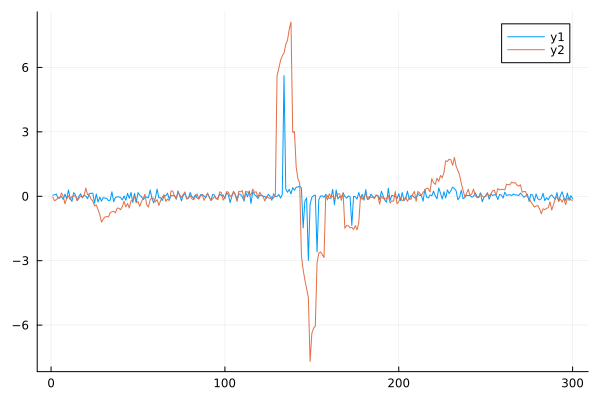

In [11]:
ds = _zs[t] .- [_zs[t][[end]];_zs[t][1:end-1]]
w = 4
ds = slw(reshape(ds,1,:), w; wrap=true)
ds = ds[1,:,:]
println(size(ds))
ds′ = sum(ds, dims=2)
println(size(ds′))

plot(ds[:,w+1])
plot!(ds′[:,1])

5-element Vector{Tuple{Float64, Vector{Float64}, Vector{Float64}}}:
 (5.621305205710297, [6.384907836346417, -2.307047723309519], [1.0895542438738313, -0.4197738060701289])
 (1.4734378372948758, [8.613422795234666, -0.9999699731320522], [10.050223410296171, -1.381371412326965])
 (2.9843231206936762, [5.374041080188836, -0.28258523627373133], [8.34317173816034, -0.6147407410910637])
 (2.588781939834172, [2.447871066636808, 0.12871733085242562], [5.037531251892604, 0.1588406151608419])
 (1.3604252147846134, [0.8187263499670419, 0.41878856927238584], [2.0512686268708777, 0.9954359262423635])

In [140]:
function get_gap_mask(zs; thresh=nothing)
    ds = zs .- [zs[2:end];zs[[1]]]
    if thresh == nothing
        thresh = mean(ds) + 2*std(ds)
    end
    return abs.(ds) .> thresh
end



get_gap_mask (generic function with 1 method)

In [141]:

mask = get_gap_mask(_zs[t], thresh=1.)
sum(mask)
segs[mask]

3-element Vector{Segment}:
 Segment([5.910351075075159, 9.375151031589859], [5.7771860162324575, 9.288495460156428])
 Segment([5.767988177441897, 9.44575261150501], [5.748616715344287, 9.482516156801669])
 Segment([5.746674568641727, 9.682711548698936], [5.60004631943587, 9.534568939364759])

In [142]:
mid(s::Segment) = s.x + (s.y-s.x)/2

mid (generic function with 1 method)

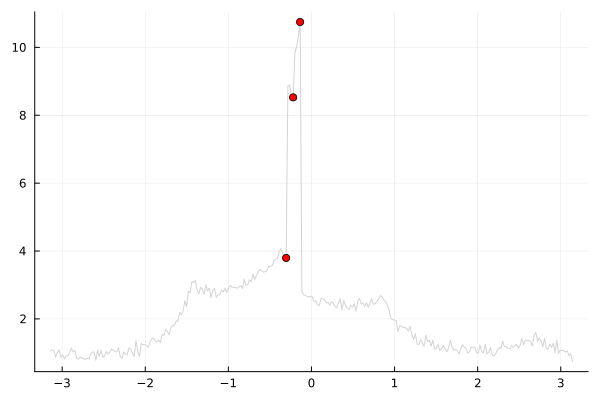

In [167]:
t = 1


ys   = polar_inv(_zs[t],_as)
segs = segments(ys.*_ps[t])
mask = get_gap_mask(_zs[t])

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:black, label="Clutter (Boxes)")



plot_rays!(_ps[t], _zs[t], _as; step=1, c=:lightgray, alpha=0.2, label=nothing)
plot!(segs[mask], c=:red, linewidth=2, alpha=0.25, label=nothing)
# scatter!(ys .* _ps[t], c=col[1], alpha=1., markerstrokewidth=0, markersize=2)
scatter!(mid.(segs[mask]), c=:red, alpha=1., markerstrokewidth=0, markersize=4, label=nothing)

plot!(_ps[t], c=:red, linewidth=3, label=nothing)

plot(_as, _zs[t], c=:lightgray, label=nothing)
scatter!(_as[mask], _zs[t][mask],c=:red, label=nothing)

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/dev/v3/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/dev/v3/tmp.gif")
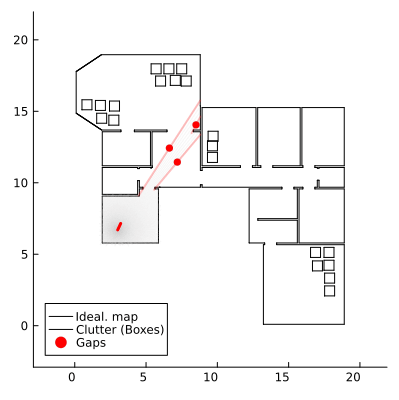

In [173]:
# -----------------------
ani = Animation()
for t=1:_T
    ys   = polar_inv(_zs[t],_as)
    segs = segments(ys.*_ps[t])
    mask = get_gap_mask(_zs[t])
    
    # -----------------------
    mypl = plot(size=(400,400), aspect_ratio=:equal, grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
    plot!(_boxes, c=:black, label="Clutter (Boxes)")

    

    plot_rays!(_ps[t], _zs[t], _as; step=1, c=:lightgray, alpha=0.2, label=nothing)
    plot!(segs[mask], c=:red, linewidth=2, alpha=0.25, label=nothing)
    # scatter!(ys .* _ps[t], c=col[1], alpha=1., markerstrokewidth=0, markersize=2)
    scatter!(mid.(segs[mask]), c=:red, alpha=1., markerstrokewidth=0, markersize=4, label="Gaps")

    plot!(_ps[t], c=:red, linewidth=3, label=nothing)
    

    

    frame(ani, mypl)
end
gif(ani, fps=2)